<a href="https://colab.research.google.com/github/jarkrandel/mnist-classifiers/blob/main/mnist_1_hidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# How good can we make a single hidden layer classifier (simple linear achieved 91.5% accuracy)?
# Processing
with open('drive/MyDrive/data/train-images.idx3-ubyte', mode='rb') as file:
    train_images_file = file.read()
with open('drive/MyDrive/data/train-labels.idx1-ubyte', mode='rb') as file:
    train_labels_file = file.read()
with open('drive/MyDrive/data/t10k-images.idx3-ubyte', mode='rb') as file:
    test_images_file = file.read()
with open('drive/MyDrive/data/t10k-labels.idx1-ubyte', mode='rb') as file:
    test_labels_file = file.read()

train_images_file = train_images_file[16:]
train_labels_file = train_labels_file[8:]
test_images_file = test_images_file[16:]
test_labels_file = test_labels_file[8:]

train_images = np.array(struct.unpack('47040000B', train_images_file)).reshape((60000,28,28))
train_labels = np.array(struct.unpack('60000B', train_labels_file))
test_images = np.array(struct.unpack('7840000B', test_images_file)).reshape((10000,28,28))
test_labels = np.array(struct.unpack('10000B', test_labels_file))

In [2]:
X_train = train_images[0:60000,:,:]
y_train = train_labels[0:60000]

X_test = test_images
y_test = test_labels

# Normalize images and apply one hot encoding to labels
X_train = ((X_train - 128) / 256).reshape(-1, 28*28)
X_test = ((X_test - 128) / 256).reshape(-1, 28*28)

def oh(y, colnum):
    y_oh = np.zeros((y.size, colnum))
    y_oh[np.arange(y.size), y] = 1
    return y_oh

y_train = oh(y_train, 10)
y_test = oh(y_test, 10)

In [3]:
# Initialize weights and outputs
layer_dims = [784, 300, 10]
num_layers = len(layer_dims) - 1

# Xavier initialization for tanh
params = {}
for i in range(num_layers):
  params['W' + str(i)] = np.random.normal(0, (5/3) / np.sqrt(layer_dims[i]), (layer_dims[i], layer_dims[i+1]))
  params['b' + str(i)] = np.random.normal(0, 1, (1, layer_dims[i+1])) * 0.01

# Initialize gradients
grads = {}
for i in range(num_layers):
  grads['W' + str(i)] = np.zeros((layer_dims[i], layer_dims[i+1]))
  grads['b' + str(i)] = np.zeros((1, layer_dims[i+1]))

In [4]:
# Defs of forward / backward passes
cache = {}

def softmax(A):
    S = np.exp(A)
    return S / np.sum(S, axis=1).reshape(S.shape[0], 1)

def forward(X, cache_on=True):
  W0, W1, b0, b1 = params['W0'], params['W1'], params['b0'], params['b1']
  # layer 0
  Z0 = np.dot(X, W0) + b0
  A0 = np.tanh(Z0)
  # layer 1
  Z1 = np.dot(A0, W1) + b1
  A1 = softmax(Z1)
  if cache_on:
    cache['A0'] = A0
    cache['A1'] = A1
  return A1

def loss(X, y):
  batch_size = X.shape[0]
  return (1 / batch_size) * np.sum(-np.log(forward(X, False)) * y)

def accuracy(X, y):
  preds = np.argmax(forward(X, False), axis=1)
  preds = oh(preds, 10)
  return (1 / X.shape[0]) * np.sum(preds * y)

# Use the forward computations to update gradients via backprop
def backward(X, y):
  W0, W1, b0, b1 = params['W0'], params['W1'], params['b0'], params['b1']
  A0, A1 = cache['A0'], cache['A1']

  # The chain rule works
  dZ1 = (1 / X.shape[0]) * (A1 - y)
  dW1 = np.dot(np.transpose(A0), dZ1)
  db1 = np.sum(dZ1, axis=0).reshape(1, -1)

  dA0 = np.dot(dZ1, np.transpose(W1))
  dZ0 = dA0 * (1 - A0*A0)
  dW0 = np.dot(np.transpose(X), dZ0)
  db0 = np.sum(dZ0, axis=0).reshape(1, -1)

  grads['W0'], grads['W1'], grads['b0'], grads['b1'] = dW0, dW1, db0, db1

In [5]:
# set parameters and initialize containers
losses = []
test_losses = []
epoch_num = 7
mb_size = 60
mb_num = 60000 // mb_size

# implement Adam optimization
lr = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [6]:
# initialize first moment and second moment moving averages
t = 1
first_moments, second_moments = {}, {}
for grad in grads:
  first_moments[grad] = np.zeros(grads[grad].shape)
  second_moments[grad] = np.zeros(grads[grad].shape)

# train
for epoch in range(epoch_num):
  # shuffle data
  X_train, y_train = shuffle(X_train, y_train)

  for i in range(mb_num):
    X_mb = X_train[i*mb_size:(i+1)*mb_size,:]
    y_mb = y_train[i*mb_size:(i+1)*mb_size]

    # make a forward pass with mini batch
    forward(X_mb)
    
    # record loss every now and then
    if i % 100 == 0:
      losses.append(loss(X_mb, y_mb))
      test_losses.append(loss(X_test, y_test))
    
    # compute gradients from mini batch
    backward(X_mb, y_mb)
    
    # moments update + step down descent
    for grad in grads:
      #print(f"first_moment shape: {first_moments[grad].shape} and second_moment shape: {second_moments[grad].shape}")
      first_moments[grad] = ((1-beta1)*first_moments[grad] + beta1*grads[grad]) / (1-beta1**t)
      second_moments[grad] = ((1-beta2)*second_moments[grad] + beta2*grads[grad]*grads[grad]) / (1-beta2**t)
      delta = lr * first_moments[grad] / (np.sqrt(second_moments[grad]) + epsilon)
      params[grad] -= delta
   
    t += 1

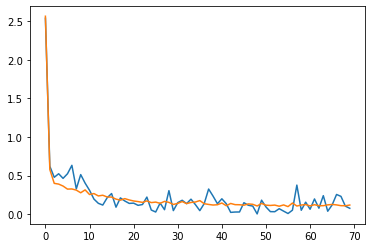

[0.10640826010097472, 0.12197881613351723, 0.10895213028655815, 0.10917040982421415, 0.11989682993048824, 0.12535925093064998, 0.11941919855206261, 0.10950641348956495, 0.10814363710945209, 0.1176527746070162]


In [7]:
plt.plot(losses)
plt.plot(test_losses)
plt.show()
print(test_losses[-10:])

In [8]:
accuracy(X_test, y_test)

0.9667

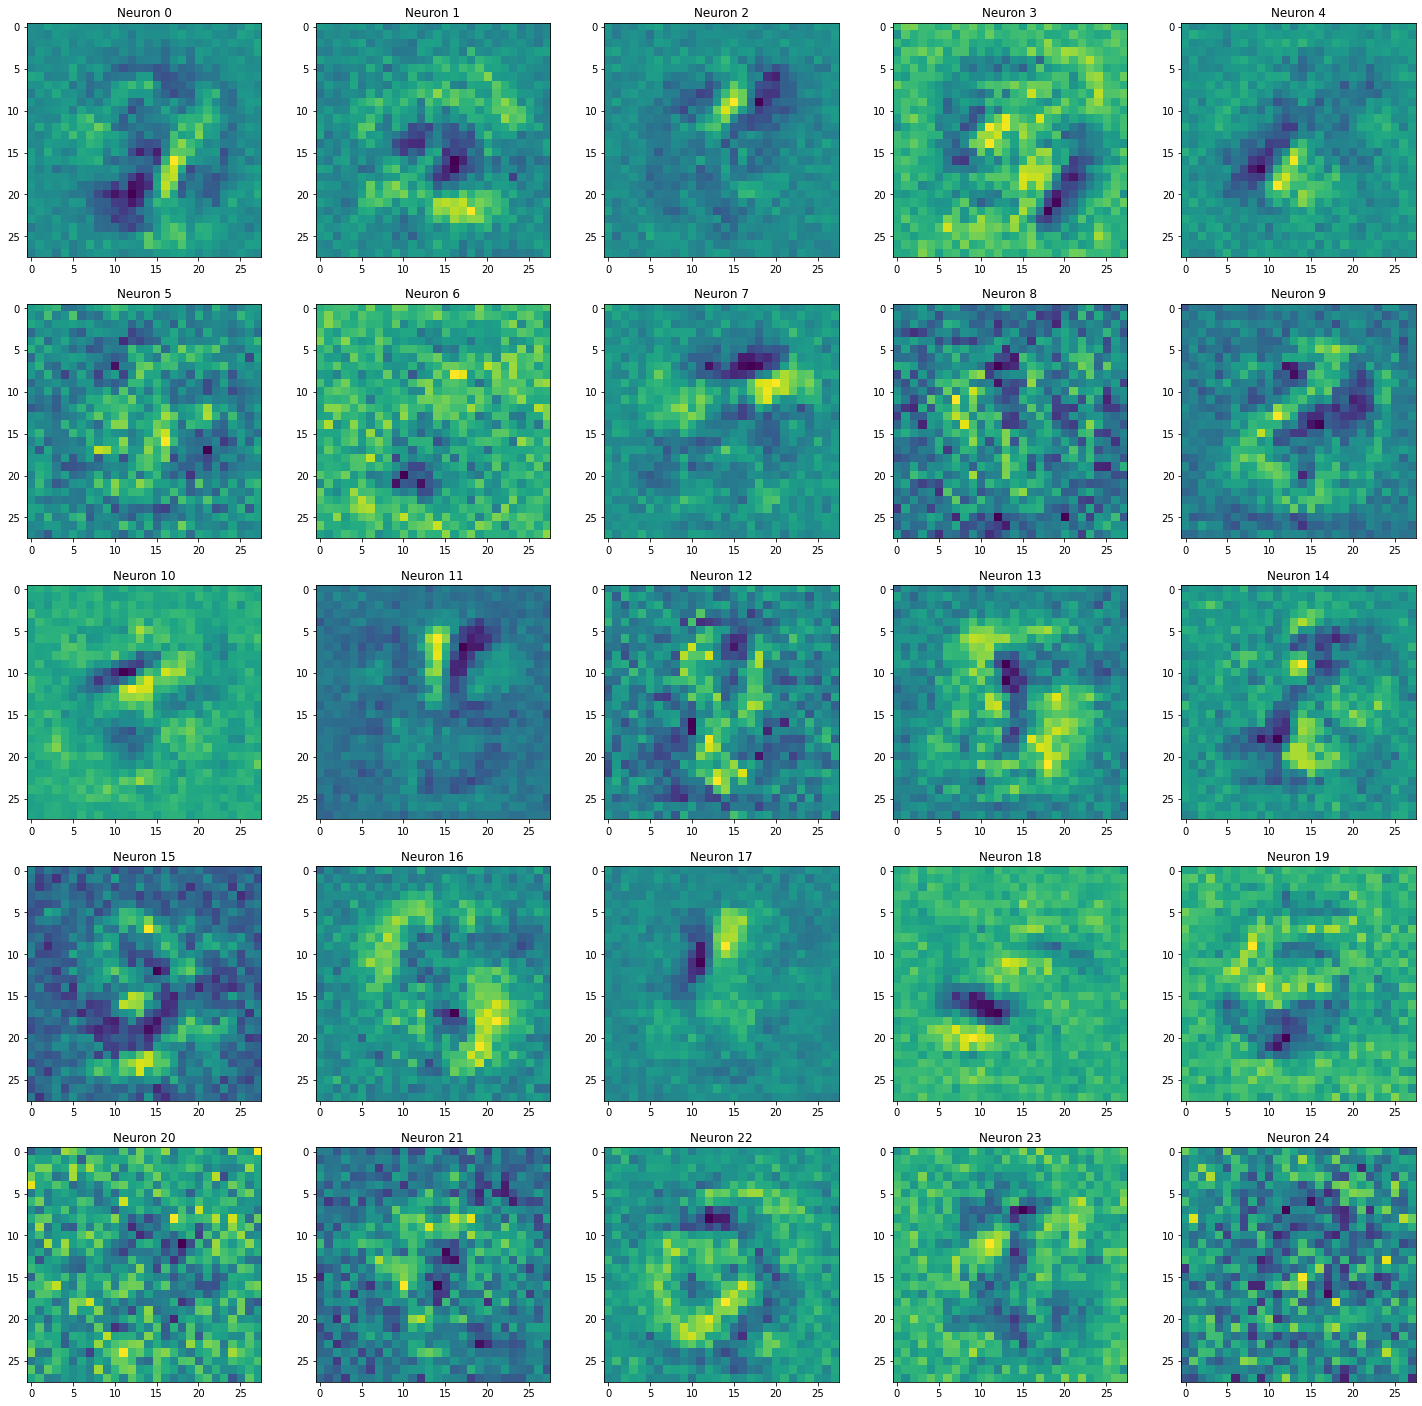

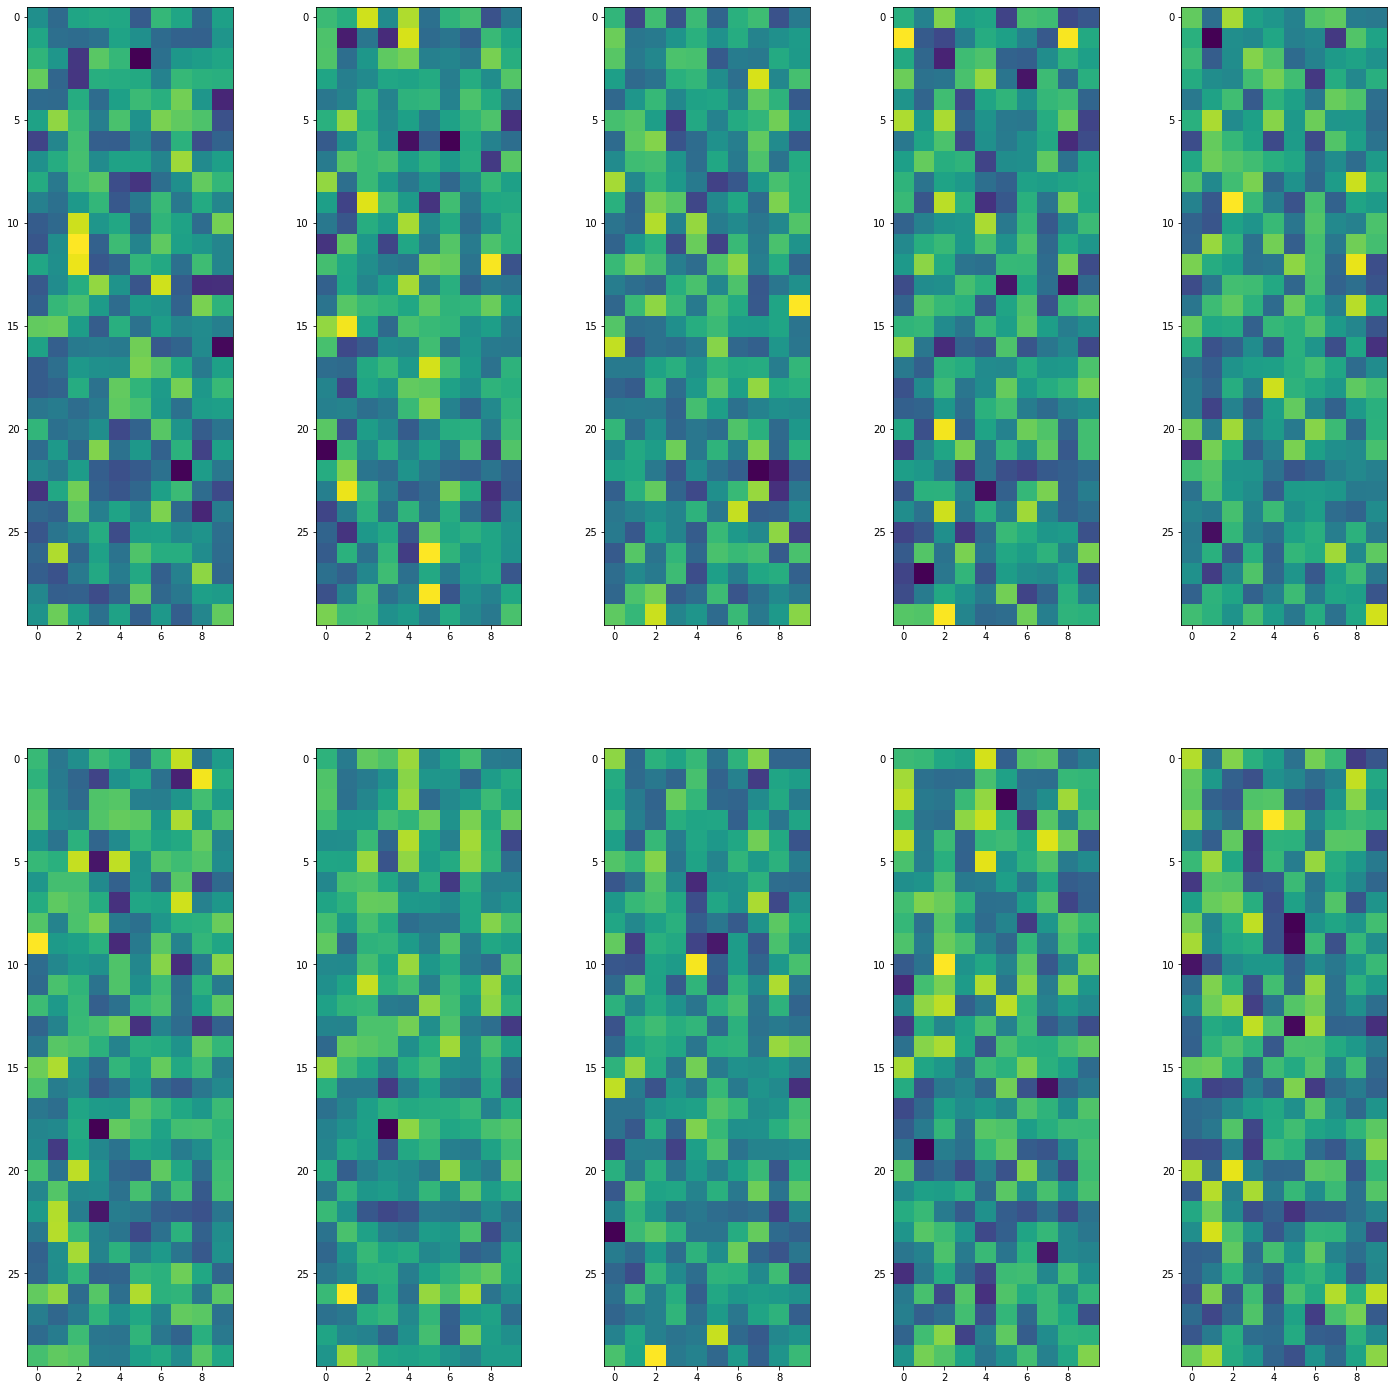

In [9]:
W0maps = params['W0'].reshape(28, 28, -1)
W1maps = params['W1'].reshape(30, 10, 10)
start, rows, cols = 0, 5, 5
# Visualize neuron ativations for each pixel location
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
for i in range(rows):
  for j in range(cols):
    ax[i,j].imshow(W0maps[:,:,start + 5*i + j])
    ax[i,j].set_title(f"Neuron {start+5*i+j}")

# Visualize neuron activations for each digit
fig2, ax2 = plt.subplots(2, 5, figsize=(25,25))
for i in range(2):
  for j in range(5):
    ax2[i,j].imshow(W1maps[:,:,5*i + j])
plt.show()